### 1. 理论知识

1. L1范数：向量元素**绝对值**之和；L2范数：向量元素平方和的**平方根**。

1. L1正则化可以使得参数稀疏化，有助于得到一个稀疏矩阵，可以用于特征选择。稀疏性，说白了就是模型的很多参数是0。

1. L2正则化可以防止模型过拟合（overfitting）；一定程度上，L1也可以防止过拟合。

2. Lasso回归是对普通线性回归使用了**L1正则**进行优化，通过惩罚或者限制估计值的绝对值之和，使得某些系数为0，从而达到特征系数化和特征选择的效果。

3. L1 范数的特性是它在零点处不可微，导致优化问题的解很可能在坐标轴上的交点处，这使得某些特征的权重会被精确地缩减至零。

4. 当我们需要一些自动的特征、变量选择，或者处理高度相关的预测因素时，推荐Lasso回归，因为标准的线性回归的系数通常太大。

5. Lasso回归的数学形式：**min(||Y-X·A||^2 + λ||A||** 

6. 正则化的理解：https://www.cnblogs.com/zingp/p/10375691.html

### 2.数据准备

##### 2.1 导入数据集

In [31]:
# 导入模块
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

# 处理数据集
ca_housing=fetch_california_housing()
X = pd.DataFrame(data=ca_housing.data, columns=ca_housing.feature_names)
y = pd.DataFrame(data=ca_housing.target, columns=["区平均售价"])

# 特征重命名
map_={
    'MedInc': '区收入中位数',
    'HouseAge': '区房屋年龄中位数',
    'AveRooms': '每户的平均房间数',
    'AveBedrms': '每户的平均卧室数',
    'Population': '区人口数',
    'AveOccup': '平每个家庭的成员数',
    'Latitude': '区组纬度',
    'Longitude': '区经度',
}
X=X.rename(columns=map_)
X

,区收入中位数,区房屋年龄中位数,每户的平均房间数,每户的平均卧室数,区人口数,平每个家庭的成员数,区组纬度,区经度
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


#### 2.2 数据处理

1. 线性回归一般公式 **y = ax + b**, 以矩阵形式呈现为 **(X·A + b =Y)**

2. 手动增加一列特征xn+1 = 1，线性回归公式则得 y = a1·x1 + a2·x2 + ... an·xn + b·xn+1，则 A=[a1,a2,...,an,b], 化为矩阵形式：**X·A = Y**，

3. 求解得A( **最小二乘法、梯度下降法** )，则b = A[-1]

**注意！！一定要对数据进行归一化，统一量纲，不然梯度下降大概率无法收敛！！**

In [32]:
from sklearn.preprocessing import Normalizer

# 数据归一化！！！！非常重要！！！！
X_1=Normalizer().fit_transform(X)

# 添加补充列1
X_1 = np.hstack((X_1,(np.ones((len(X_1), 1)))))

# 最后将y array化，方便后续计算，矩阵乘法@符号，和A.dot(B)形式都要求为array，否则只能用np.dot(A,B)
y=y.values

### 3. 算法实现

#### 3.1 梯度下降

**梯度下降思想**：

1. 相比于标准回归，Lasso回归增加了 **λ|A|** 惩罚，损失函数为**J(A) = (1/2n) · ( X·A − Y )^2 + λ·|A| ，** ,（1/2n中的2是为了求导后使得前面的系数为1），

2. 在Lasso回归中，损失函数由数据误差项（均方误差）和L1正则化项组成。L1正则化项的梯度，是正则化参数λ 与参数矩阵A中参数的符号函数的乘积。

3.  L1正则化项的梯度：𝜆⋅sign(𝐴)，**ΔA = gradient = (1/n)·X.T·(X·A - Y) + λ·sign(A)**

In [33]:
from sklearn.metrics import mean_squared_error as mse

# 设置迭代次数与下降速率
n_iterations = 1000
learning_rate = 0.01
lambda_val=-1

# 设置随机初始 A
loss_his=[]
A = np.random.rand(X_1.shape[1], 1)
n = X_1.shape[0]

for _ in range(n_iterations):

    # 梯度求解：核心公式！！！！！
    gradients = (1/n)*X_1.T @ (X_1 @ A - y)+lambda_val * np.sign(A)
    
    # 参数迭代
    A = A - learning_rate * gradients
    
    # 求损失值
    loss=mse(X_1@A,y)
    loss_his.append(loss)

    

# MSE均方误差
pred_y = np.dot(X_1,A)
print("MSE均方误差：",mse(pred_y,y))

MSE均方误差： 2.5682211439280733


<Axes: >

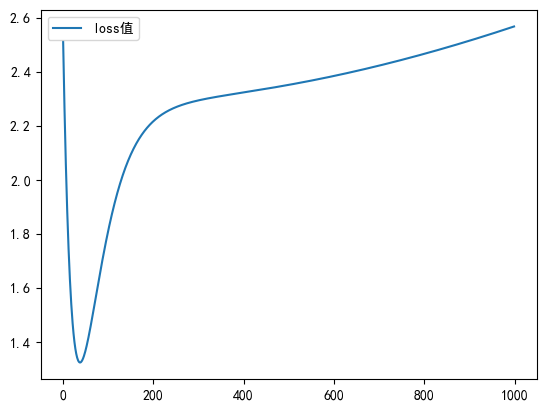

In [34]:
# 绘图设置
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'

pd.DataFrame(data=loss_his,columns=["loss值"]).plot()

### 4. 总结

1. Lasso回归由于增加了正则化惩罚项，而正则化项是非光滑的，所以其损失函数不再是凸函数，无法使用正规方程解法

2. 对于Lasso回归的L1正则化项，λ|A|,即L1范数，其导数为符号函数

3. 对于岭回归的L2正则化项，λ|A|^2，即L2范数，其导数是参数本身：2λ·A,即参数向量（矩阵）A的常数倍。
